Import Libraries

In [ ]:
import h5py
import pandas as pd
import sklearn
import sklearn.model_selection
import torch
import torch.nn.functional as F
from torch.nn.functional import one_hot
import torch.nn as nn
from google.colab import files
import io
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

Import Physics Sample Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Process Sample Data

In [ ]:
file = h5py.File("/content/drive/MyDrive/Colab_Notebooks/Data_Fuchs_v_0_lambda_um_0.8_points_100000_seed_0.h5",'r')
file_dict = dict()

for i in file.keys():
    file_dict[i] = file[i][:]
file.close()

physics = pd.DataFrame(file_dict)
# physics.info()

Splitting the data for training and testing.

In [ ]:
physics_norm = physics.copy()
total_count = len(physics)
# print(physics)
# print(total_count)

for column in physics_norm:
    physics_norm[column] = (physics_norm[column] - physics_norm[column].mean())/physics_norm[column].std()

physics_train_norm, physics_test_norm = sklearn.model_selection.train_test_split(physics_norm, train_size=0.8, random_state=1)

print(physics.head())
print(physics_norm.head())

   Intensity_(W_cm2)  Max_Proton_Energy_(MeV)  Pulse_Duration_(fs)  \
0       4.430375e+19                26.342629           276.923395   
1       1.398196e+20                23.447607           453.941239   
2       6.431172e+19                22.036055           261.150353   
3       4.311710e+19                 0.180223            68.417606   
4       1.866227e+19                 4.596437           273.239350   

   Spot_Size_(FWHM um)  Target_Thickness (um)  
0             7.890441               4.746512  
1             1.454827              11.951370  
2             9.977904              19.758459  
3             1.609050              19.041907  
4             2.885191               7.187944  
   Intensity_(W_cm2)  Max_Proton_Energy_(MeV)  Pulse_Duration_(fs)  \
0          -0.441922                -0.086202             0.114213   
1          -0.021070                -0.143620             1.391615   
2          -0.353765                -0.171616             0.000391   
3          

Plot the data for better context

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


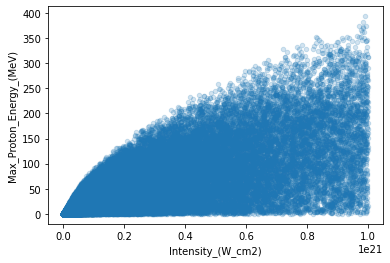

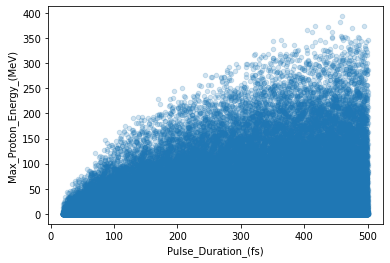

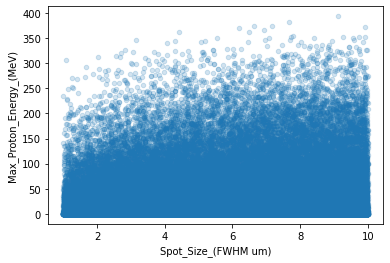

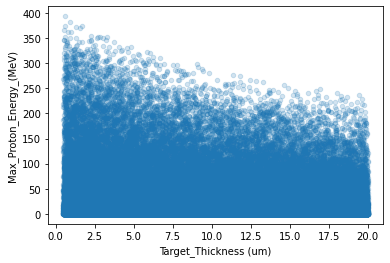

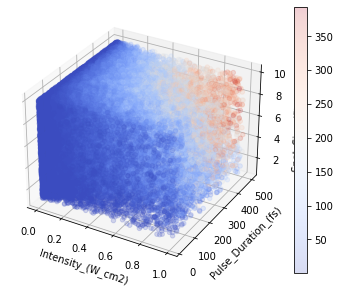

In [ ]:
physics.plot(
    x="Intensity_(W_cm2)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)
physics.plot(
    x="Pulse_Duration_(fs)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)
physics.plot(
    x="Spot_Size_(FWHM um)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)
physics.plot(
    x="Target_Thickness (um)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
p = ax.scatter(physics["Intensity_(W_cm2)"], physics["Pulse_Duration_(fs)"], physics["Spot_Size_(FWHM um)"], c=physics["Max_Proton_Energy_(MeV)"], cmap=cm.coolwarm, alpha=0.2)
fig.colorbar(p, ax=ax)
ax.set_xlabel("Intensity_(W_cm2)")
ax.set_ylabel("Pulse_Duration_(fs)")
ax.set_zlabel("Spot_Size_(FWHM um)")
fig.tight_layout()
fig.show()


# Defining a Model
*We are going to begin with using a DNN with 2 hidden layers and 16 neurons per layer. We are goiung to need to find w and b from Yhat = w times x+b where w is the weight of each function x and b is the bias on the neuron.*

*Begin with trying to predict Max_proton_energy from the other vars.*

Create the model structure

In [ ]:
torch.set_default_dtype(torch.float64)
# class RegressionNetwork(nn.Module):
#   def __init__(self):
#     super(RegressionNetwork, self).__init__()

#     self.linear1 = torch.nn.Linear(4, 64)
#     self.activation1 = torch.nn.ReLU()
#     self.linear2 = torch.nn.Linear(64, 8)
#     self.activation2 = torch.nn.ReLU()
#     self.linear3 = torch.nn.Linear(8, 1)

#   def forward(self, x):
#     x = self.linear1(x)
#     x = self.activation1(x)
#     x = self.linear2(x)
#     x = self.activation2(x)
#     x = self.linear3(x)
#     return x

class BACKRegressionNetwork(nn.Module):
  def __init__(self):
    super(BACKRegressionNetwork, self).__init__()

    self.linear1 = torch.nn.Linear(1, 8)
    self.activation1 = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(8, 64)
    self.activation2 = torch.nn.ReLU()
    self.linear3 = torch.nn.Linear(64, 4)

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation1(x)
    x = self.linear2(x)
    x = self.activation2(x)
    x = self.linear3(x)
    return x

Define our custom dataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data, transform=None, target_transform=None):
    self.labels = data[list(set(physics.columns) - {'Max_Proton_Energy_(MeV)'})].values
    self.inputs = data['Max_Proton_Energy_(MeV)'].values
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    ret_input = self.inputs[idx]
    ret_label = self.labels[idx]

    if self.transform:
        ret_input = self.transform(ret_input)
    if self.target_transform:
        ret_label = self.target_transform(ret_label)
    return ret_input, ret_label


Partition our data for training and testing. (80-20)

In [ ]:
train_data = CustomDataset(physics_train_norm)
test_data = CustomDataset(physics_test_norm)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=4)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=4)

print('Training set has {} instances'.format(len(train_dataloader)))
print('Test set has {} instances'.format(len(test_dataloader)))

feature, label = next(iter(train_dataloader))

print(f"Feature batch shape: {feature} - {label}")


Training set has 20000 instances
Test set has 5000 instances
Feature batch shape: tensor([-0.5899,  2.8364, -0.2229,  1.7054]) - tensor([[-0.5408, -1.3208, -0.8204, -1.2484],
        [ 1.0711,  0.1678, -1.0197,  1.6176],
        [-0.3865, -1.1150,  0.3629,  1.5904],
        [ 2.4507, -0.4900,  1.4164,  1.0777]])


Define our training loop

In [ ]:
# x = torch.randn(1, 4)
# x = torch.tensor([1.0711,  0.1678, -1.0197,  1.6176])
# print(x)

# x = torch.transpose(x, 0, 1)
# print(x)

In [ ]:
model = BACKRegressionNetwork()

print("Model Shape: ")
for parameter in model.parameters():
  print(parameter.dtype)
  print(parameter.shape)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = torch.nn.MSELoss()

def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0.
  last_loss = 0.

  for i, data in enumerate(train_dataloader):

    inputs, label = data
    # print(f'inputs: {torch.unsqueeze(inputs, 1)} \nLabels: {label}')
    optimizer.zero_grad()

    # Prediction
    outputs = torch.squeeze(model(torch.unsqueeze(inputs, 1)), 1)

    # print(f'outputs: {outputs}')

    # Get the loss and the gradient
    loss = loss_function(outputs, label)
    loss.backward()

    # Adjust the weights
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        tb_x = epoch_index * len(train_dataloader) + i + 1
        tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.

  return last_loss

Model Shape: 
torch.float64
torch.Size([8, 1])
torch.float64
torch.Size([8])
torch.float64
torch.Size([64, 8])
torch.float64
torch.Size([64])
torch.float64
torch.Size([4, 64])
torch.float64
torch.Size([4])


per epoch activity loop

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 40
epoch_train_loss = []
epoch_test_loss = []

best_tloss = 1_000_000

for epoch in range(EPOCHS):
  print('EPOCH {}:'.format(epoch_number + 1))

  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  model.train(False)
  running_vloss = 0.0

  # Test how well its trained
  for i, tdata in enumerate(test_dataloader):
    tinputs, tlabels = tdata

    toutputs = torch.squeeze(model(torch.unsqueeze(tinputs, 1)), 1)
    tloss = loss_function(toutputs, tlabels)
    running_vloss += tloss

  avg_tloss = running_vloss / (i + 1)
  print('LOSS train {} testing {}'.format(avg_loss, avg_tloss))
  epoch_train_loss.append(avg_loss)
  epoch_test_loss.append(avg_tloss.detach().numpy())

  # Log the running loss averaged per batch
  # for both training and validation
  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_tloss },
                    epoch_number + 1)
  writer.flush()

  # Track best performance, and save the model's state
  # if avg_tloss < best_tloss:
  #     best_vloss = avg_tloss
  #     model_path = '/content/drive/MyDrive/Colab_Notebooks/models/model_{}_{}'.format(timestamp, epoch_number)
  #     torch.save(model.state_dict(), model_path)

  epoch_number += 1


EPOCH 1:
  batch 1000 loss: 0.8481283620291006
  batch 2000 loss: 0.7999986687677575
  batch 3000 loss: 0.8083354472656733
  batch 4000 loss: 0.8027057421891258
  batch 5000 loss: 0.8028977373719047
  batch 6000 loss: 0.8089587675647957
  batch 7000 loss: 0.8018061278112953
  batch 8000 loss: 0.8136178038867261
  batch 9000 loss: 0.8103949212967978
  batch 10000 loss: 0.8117615075757502
  batch 11000 loss: 0.8082106446534238
  batch 12000 loss: 0.8063829448154214
  batch 13000 loss: 0.8043429900719712
  batch 14000 loss: 0.8004405067359103
  batch 15000 loss: 0.8074849846105022
  batch 16000 loss: 0.8068329415405044
  batch 17000 loss: 0.7948893852274231
  batch 18000 loss: 0.7944907413705065
  batch 19000 loss: 0.8181701356851203
  batch 20000 loss: 0.813768043891385
LOSS train 0.813768043891385 testing 0.8066524973467277
EPOCH 2:
  batch 1000 loss: 0.8092262261804133
  batch 2000 loss: 0.7923157981511605
  batch 3000 loss: 0.8040436674220479
  batch 4000 loss: 0.7989975842577863
  ba

Plot error over time

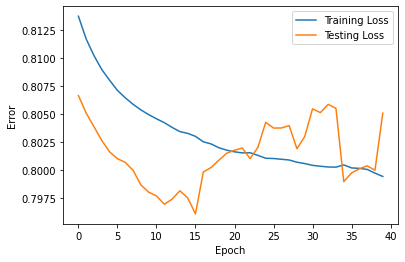

In [ ]:
plt.plot(epoch_train_loss, label='Training Loss')
plt.plot(epoch_test_loss, label='Testing Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

These results show that simply inverting the model does not work. Training something with 1 input and many outputs is extremly difficult.